In [1]:
!pwd

/content


In [2]:
import numpy as np 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import imshow
import pandas as pd

In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [4]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [5]:
%cd /content/gdrive/MyDrive/Folder/

/content/gdrive/MyDrive/Folder


In [6]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-lnjwm2a0
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-lnjwm2a0
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=179891 sha256=cde6c78104960778ff938d07d3ec7e1cc314a18e0ef8ed880e12cd96c5296485
  Stored in directory: /tmp/pip-ephem-wheel-cache-gl5elqu9/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [7]:
from PIL import Image
def undersample(df, count, rs=42):
  result=[]
  df_group = df.groupby('dx')
  for x in df['dx'].unique():
    group = df_group.get_group(x)
    num = int(group['dx'].value_counts())
    if num >= count:
      s=group.sample(count, axis=0, random_state=rs)
    else:
      s=group.sample(frac=1, axis=0, random_state=rs)
    result.append(s)
  return pd.concat(result, axis=0).reset_index(drop=True)

def oversample(df, count, rs=42):
  lst = [df]
  for class_index, group in df.groupby('dx'):
      lst.append(group.sample(count-len(group), replace=True, random_state=rs))
  df_new = pd.concat(lst)
  return df_new

def img_np_convert(df, image_path, h, w):
  df['image_id'] = image_path + df['image_id'] +'.jpg'
  df['image'] = df['image_id'].map(lambda x: np.asarray(Image.open(x).resize((h, w))).astype(np.float32))
  return df

def img_np_convert_scaled(df, image_path, h, w):
  df['image_id'] = image_path + df['image_id'] +'.jpg'
  df['image'] = df['image_id'].map(lambda x: (np.asarray(Image.open(x).resize((h, w)))/255).astype(np.float32))
  return df

def my_split(df, train_size, test_size, val_size, rs=42):
  valid_test_split = val_size / test_size

  df_train, df_test_val = train_test_split(df, test_size=1-train_size, shuffle=True, random_state=rs)
  df_val, df_test = train_test_split(df_test_val, test_size=valid_test_split, shuffle=True, random_state=rs)

  df_train.reset_index(inplace=True)
  return df_train, df_test, df_val

def weight_cal(df):
  class_weight={}
  labels = list(df['dx'].unique())
  labels.sort()
  count = df['dx'].value_counts()
  for idx in range(7):
    class_weight[idx] = count['nv']/count[labels[idx]]
  return class_weight, labels

def df_to_np1(df):
  image = np.asarray(df['image'].to_list()) 
  target_df = df['dx']
  target = pd.get_dummies(data=target_df, columns=['dx']).to_numpy()
  return image, target

def df_to_np2(df):
  df['image'] = df['image'].map(lambda x : x.flatten())
  i_feature = np.asarray(df['image'].tolist())
  df_feature = df.iloc[:, 3:-1]
  c_feature = df_feature.loc[:, ~df_feature.columns.isin(['sex', 'dx'])].to_numpy()
  features = np.concatenate((i_feature, c_feature), axis=1)
  
  target_df = df['dx']
  target = pd.get_dummies(data=target_df, columns=['dx']).to_numpy()
  return features, target

def image_augment(df, target, count, size, rs=42):
  df_group = df.groupby('dx')
  group = df_group.get_group(target)
  s=group.sample(count, axis=0, random_state=rs)

  datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    fill_mode='nearest')
  
  for index, row in s.iterrows():
    image = row['image'].reshape((1, ) + row['image'].shape)
    gen = datagen.flow(image, batch_size=size)
    input = row.to_list()
    for i in range(size):
      img = next(gen)
      input[-1] = img[0]
      df.loc[len(df.index)] = input
  return None

In [8]:
def prep_pipeline2(upper_size, h, w, aug_targets, aug_count, aug_size, rs=42):
  df_o = pd.read_csv('/content/gdrive/MyDrive/Folder/data/HAM10000_metadata.csv')
  df_o = pd.get_dummies(data=df_o, columns=['dx_type', 'localization'])
  image_path = '/content/gdrive/MyDrive/Folder/images/'
  df_u = undersample(df_o, upper_size)
  df_u['age'].fillna(value=int(df_u['age'].mean()), inplace=True)
  df_u['age'] = df_u['age'].astype(np.float32)

  df = img_np_convert_scaled(df_u, image_path, h, w)

  df_train, df_test, df_val = my_split(df, 0.7, 0.2, 0.1, rs)

  for target in aug_targets:
    image_augment(df_train, target, aug_count, aug_size, rs)

  weight, labels = weight_cal(df_train)

  X_train, y_train = df_to_np2(df_train)
  X_test, y_test = df_to_np2(df_test)
  X_val, y_val = df_to_np2(df_val)
  return (X_train, y_train), (X_test, y_test), (X_val, y_val), weight, labels

In [9]:
h = 90
w = 90
aug_targets = ['mel', 'bcc']
aug_count = 50
aug_size = 4
majority = 6000

train_set, test_set, val_set, class_weight, labels = prep_pipeline2(majority, h, w, aug_targets, aug_count, aug_size)

In [10]:
X_train = train_set[0]
y_train = np.argmax(train_set[1], axis=1)

X_val = val_set[0]
y_val = np.argmax(val_set[1], axis=1)

X_test = test_set[0]
y_test = np.argmax(test_set[1], axis=1)

In [11]:
print(X_train.shape, X_test.shape, X_val.shape)

(6916, 24320) (1397, 24320) (1397, 24320)


In [16]:
from sklearn import linear_model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier

In [21]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(class_weight=class_weight)

lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
lr_train = accuracy_score(y_train, y_train_pred)
lr_test = accuracy_score(y_test, y_test_pred)
print('Logistic train/test accuracies %.3f/%.3f' % (lr_train, lr_test))


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Logistic train/test accuracies 0.613/0.578


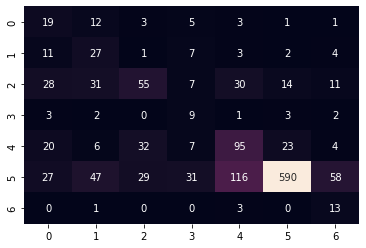

In [23]:
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False)

In [24]:
clr = classification_report(y_test, y_test_pred, target_names=labels)
print(clr)

              precision    recall  f1-score   support

       akiec       0.18      0.43      0.25        44
         bcc       0.21      0.49      0.30        55
         bkl       0.46      0.31      0.37       176
          df       0.14      0.45      0.21        20
         mel       0.38      0.51      0.43       187
          nv       0.93      0.66      0.77       898
        vasc       0.14      0.76      0.24        17

    accuracy                           0.58      1397
   macro avg       0.35      0.52      0.37      1397
weighted avg       0.73      0.58      0.63      1397



In [28]:
bag = BaggingClassifier(base_estimator=lr,n_estimators=10,bootstrap=True,random_state=1)

In [29]:
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print('Bagging train/test accuracies %.3f/%.3f'% (bag_train, bag_test))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Bagging train/test accuracies 0.625/0.591


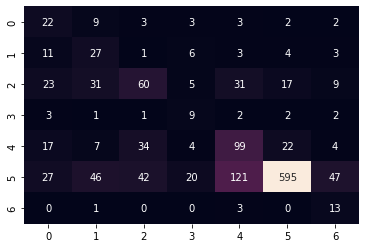

In [31]:
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False)

In [32]:
from sklearn.tree import DecisionTreeClassifier
dtree_model = DecisionTreeClassifier(max_depth = 6).fit(X_train, y_train)
dtree_model.fit(X_train, y_train)
y_train_pred = dtree_model.predict(X_train)
y_test_pred = dtree_model.predict(X_test)
dtree_model_train = accuracy_score(y_train, y_train_pred)
dtree_model_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f' % (dtree_model_train, dtree_model_test))


Decision tree train/test accuracies 0.725/0.696


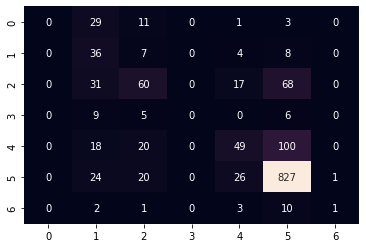

In [33]:
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False)

In [34]:
clr = classification_report(y_test, y_test_pred, target_names=labels)
print(clr)

              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        44
         bcc       0.24      0.65      0.35        55
         bkl       0.48      0.34      0.40       176
          df       0.00      0.00      0.00        20
         mel       0.49      0.26      0.34       187
          nv       0.81      0.92      0.86       898
        vasc       0.50      0.06      0.11        17

    accuracy                           0.70      1397
   macro avg       0.36      0.32      0.29      1397
weighted avg       0.66      0.70      0.67      1397



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
bag = BaggingClassifier(base_estimator=dtree_model,n_estimators=10,bootstrap=True,random_state=1)

In [36]:
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print('Bagging train/test accuracies %.3f/%.3f'% (bag_train, bag_test))

Bagging train/test accuracies 0.757/0.720


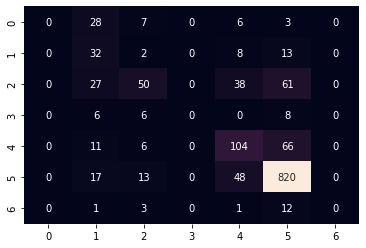

In [37]:
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False)

In [38]:
clr = classification_report(y_test, y_test_pred, target_names=labels)
print(clr)

              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        44
         bcc       0.26      0.58      0.36        55
         bkl       0.57      0.28      0.38       176
          df       0.00      0.00      0.00        20
         mel       0.51      0.56      0.53       187
          nv       0.83      0.91      0.87       898
        vasc       0.00      0.00      0.00        17

    accuracy                           0.72      1397
   macro avg       0.31      0.33      0.31      1397
weighted avg       0.69      0.72      0.69      1397



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
from sklearn.svm import SVC
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train)

svm_model_linear.fit(X_train, y_train)
y_train_pred = svm_model_linear.predict(X_train)
y_test_pred = svm_model_linear.predict(X_test)
svm_model_linear_train = accuracy_score(y_train, y_train_pred)
svm_model_linear_test = accuracy_score(y_test, y_test_pred)
print('Linear SVM train/test accuracies %.3f/%.3f' % (svm_model_linear_train, svm_model_linear_test))


Linear SVM train/test accuracies 1.000/0.716


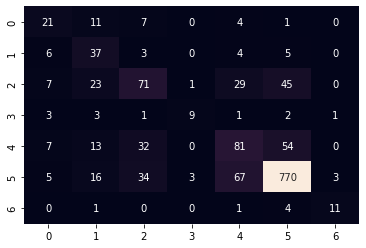

In [40]:
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False)

In [41]:
clr = classification_report(y_test, y_test_pred, target_names=labels)
print(clr)

              precision    recall  f1-score   support

       akiec       0.43      0.48      0.45        44
         bcc       0.36      0.67      0.47        55
         bkl       0.48      0.40      0.44       176
          df       0.69      0.45      0.55        20
         mel       0.43      0.43      0.43       187
          nv       0.87      0.86      0.87       898
        vasc       0.73      0.65      0.69        17

    accuracy                           0.72      1397
   macro avg       0.57      0.56      0.56      1397
weighted avg       0.73      0.72      0.72      1397



In [42]:
bag = BaggingClassifier(base_estimator=svm_model_linear,n_estimators=10,bootstrap=True,random_state=1)

In [ ]:
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print('Bagging train/test accuracies %.3f/%.3f'% (bag_train, bag_test))

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False)

In [ ]:
clr = classification_report(y_test, y_test_pred, target_names=labels)
print(clr)

In [ ]:
svm_model_non = SVC(kernel='rbf', C = 1).fit(X_train, y_train)
print(svm_model_non.score(X_train, y_train))
print(svm_model_non.score(X_val, y_val))
print(svm_model_non.score(X_test, y_test))


0.7083574320416426
0.7208303507516106
0.7093772369362921


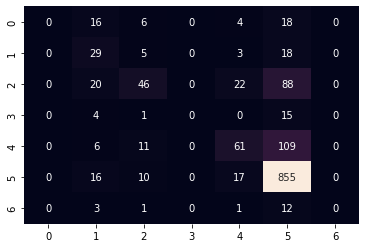

In [ ]:
y_pred = svm_model_non.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False)

In [ ]:
clr = classification_report(y_test, y_pred, target_names=labels)
print(clr)

              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        44
         bcc       0.31      0.53      0.39        55
         bkl       0.57      0.26      0.36       176
          df       0.00      0.00      0.00        20
         mel       0.56      0.33      0.41       187
          nv       0.77      0.95      0.85       898
        vasc       0.00      0.00      0.00        17

    accuracy                           0.71      1397
   macro avg       0.32      0.30      0.29      1397
weighted avg       0.65      0.71      0.66      1397



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 7).fit(X_train, y_train)
print(knn.score(X_train, y_train))
print(knn.score(X_val, y_val))
print(knn.score(X_test, y_test))


In [ ]:
y_pred = knn.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False)

In [ ]:
clr = classification_report(y_test, y_pred, target_names=labels)
print(clr)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=6, random_state=0, class_weight=class_weight)
rf.fit(X_train, y_train)
print(rf.score(X_train, y_train))
print(rf.score(X_val, y_val))
print(rf.score(X_test, y_test))

In [ ]:
y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)

In [ ]:
clr = classification_report(y_test, y_pred, target_names=labels)
print(clr)